In [106]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
download_list=os.listdir("Downloads/input")
print(download_list)

['sampleSubmission.csv', 'test1', 'train']


In [107]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [108]:
filenames = os.listdir("Downloads/input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

In [109]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [110]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [111]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


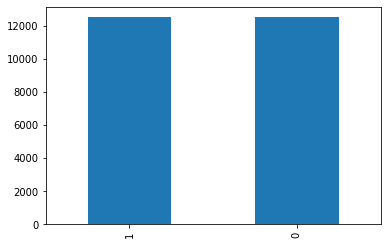

In [112]:
df['category'].value_counts().plot.bar()

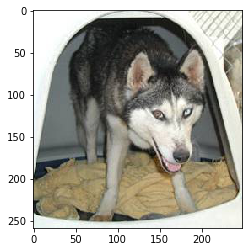

In [113]:
sample=random.choice(filenames)
image=load_img("Downloads/input/train/"+sample)
plt.imshow(image)

In [114]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [115]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
__________

In [116]:
earlystop=EarlyStopping(patience=10)

In [117]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [118]:
callbacks=[earlystop,learning_rate_reduction]

In [119]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [120]:
train_df, validate_df = train_test_split(df,train_size=20,test_size=20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

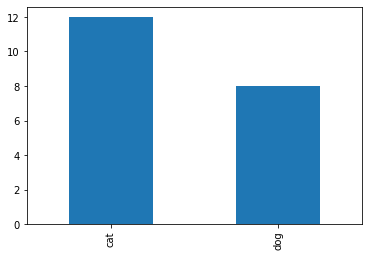

In [121]:
train_df['category'].value_counts().plot.bar()

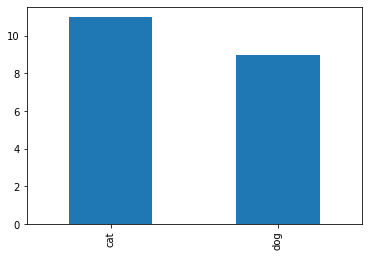

In [122]:
validate_df['category'].value_counts().plot.bar()

In [123]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [124]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [125]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Downloads/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20 validated image filenames belonging to 2 classes.


In [126]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Downloads/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20 validated image filenames belonging to 2 classes.


In [135]:
epochs=12 #if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
      epochs=epochs
)

Epoch 1/12
1/1 [==============================] - 1s 734ms/step - loss: 2.1964 - acc: 0.2000 - val_loss: 2.6426 - val_acc: 0.4000
Epoch 2/12
1/1 [==============================] - 1s 1s/step - loss: 0.3998 - acc: 0.8667 - val_loss: 1.6680 - val_acc: 0.5333
Epoch 3/12
1/1 [==============================] - 1s 628ms/step - loss: 0.7221 - acc: 0.6000 - val_loss: 4.1936 - val_acc: 0.2000
Epoch 4/12
1/1 [==============================] - 1s 1s/step - loss: 0.6810 - acc: 0.8667 - val_loss: 2.5974 - val_acc: 0.3333

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 5/12
1/1 [==============================] - 1s 635ms/step - loss: 0.6370 - acc: 0.8000 - val_loss: 0.9220 - val_acc: 0.8000
Epoch 6/12
1/1 [==============================] - 1s 1s/step - loss: 0.6275 - acc: 0.8000 - val_loss: 1.4859 - val_acc: 0.4667
Epoch 7/12
1/1 [==============================] - 1s 625ms/step - loss: 0.3906 - acc: 0.8000 - val_loss: 4.8682 - val_acc: 0.4000

Epoch 00007: Redu

In [128]:
model.save_weights("model.h5")

In [134]:
submission = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

submission.to_csv('submission.csv',index=False)